<a href="https://colab.research.google.com/github/ZaKSa/Machine-learning/blob/main/ML_07_%D0%A4%D0%B8%D0%BD%D0%B0%D0%BD%D1%81%D0%BE%D0%B2%D0%B0%D1%8F_%D1%8D%D0%BA%D0%BE%D0%BD%D0%BE%D0%BC%D0%B5%D1%82%D1%80%D0%B8%D0%BA%D0%B0_%D0%BD%D0%B0_Python__VaR_%D0%BF%D0%BE%D1%80%D1%82%D1%84%D0%B5%D0%BB%D1%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Моделирование VaR портфеля
1. Работа с временными рядами
2. Различные подходы
   - Произведение одномерных распределений
   - Многомерные распределения
   - Копулы
3. Бектестирование
   - Тест Купика

In [ ]:
# # Раскомментировать, если не установлены 
!pip install yfinance
!pip install arch
!pip install copulae
# # https://copulae.readthedocs.io/en/latest/getting-started.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 918.2/918.2 kB 13.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 29.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns

import yfinance as yf
from arch import arch_model 

plt.style.use("bmh")
%config InlineBackend.figure_formats=["png"]

## Данные

Скачиваем котировки компаний Apple, HSBC, Toyota, Amazon,  Google

In [ ]:
data = yf.download("AAPL HSBC TM AMZN GOOG", start="2017-01-01", end="2022-01-01", group_by="ticker")

data.head()

[*********************100%***********************]  5 of 5 completed


AMZN                                                         \
                 Open       High        Low      Close  Adj Close     Volume   
Date                                                                           
2017-01-03  37.896000  37.938000  37.384998  37.683498  37.683498   70422000   
2017-01-04  37.919498  37.984001  37.709999  37.859001  37.859001   50210000   
2017-01-05  38.077499  39.119999  38.013000  39.022499  39.022499  116602000   
2017-01-06  39.118000  39.972000  38.924000  39.799500  39.799500  119724000   
2017-01-09  39.900002  40.088501  39.588501  39.846001  39.846001   68922000   

                 GOOG                                   ...       HSBC  \
                 Open       High        Low      Close  ...        Low   
Date                                                    ...              
2017-01-03  38.940498  39.481499  38.790001  39.306999  ...  40.740002   
2017-01-04  39.417999  39.567001  39.158001  39.345001  ...  40.840000   
2017-01-05  39.304001  39.723999  39.250999  39.701000  ...  40.919998   
2017-01-06  39.763000  40.395000  39.610199  40.307499  ...  41.040001   
2017-01-09  40.320000  40.498299  40.141499  40.332500  ...  40.619999   

                                                   TM                          \
                Close  Adj Close   Volume        Open        High         Low   
Date                                                                            
2017-01-03  40.889999  29.868019  2353000  118.169998  118.669998  117.830002   
2017-01-04  41.279999  30.152884  1398700  120.269997  121.290001  120.139999   
2017-01-05  41.160000  30.065235  1573900  121.190002  121.389999  120.320000   
2017-01-06  41.150002  30.057930  2313300  119.839996  120.230003  119.410004   
2017-01-09  40.660000  29.700010  1896500  119.480003  119.959999  119.470001   

                                            
                 Close   Adj Close  Volume  
Date                                        
2017-01-03  118.550003  118.550003  204000  
2017-01-04  121.190002  121.190002  250600  
2017-01-05  120.440002  120.440002  525900  
2017-01-06  120.129997  120.129997  171600  
2017-01-09  119.739998  119.739998  135800  

[5 rows x 30 columns]

In [ ]:
prices = []

for ticker in data.columns.levels[0]:

    temp = data[ticker]['Close']
    temp.name = ticker
    prices.append(temp)

prices = pd.concat(prices, axis=1)

prices.head()

,AAPL,AMZN,GOOG,HSBC,TM
Date,,,,,
2017-01-03,29.037500,37.683498,39.306999,40.889999,118.550003
2017-01-04,29.004999,37.859001,39.345001,41.279999,121.190002
2017-01-05,29.152500,39.022499,39.701000,41.160000,120.440002
2017-01-06,29.477501,39.799500,40.307499,41.150002,120.129997
2017-01-09,29.747499,39.846001,40.332500,40.660000,119.739998


Строим график цен

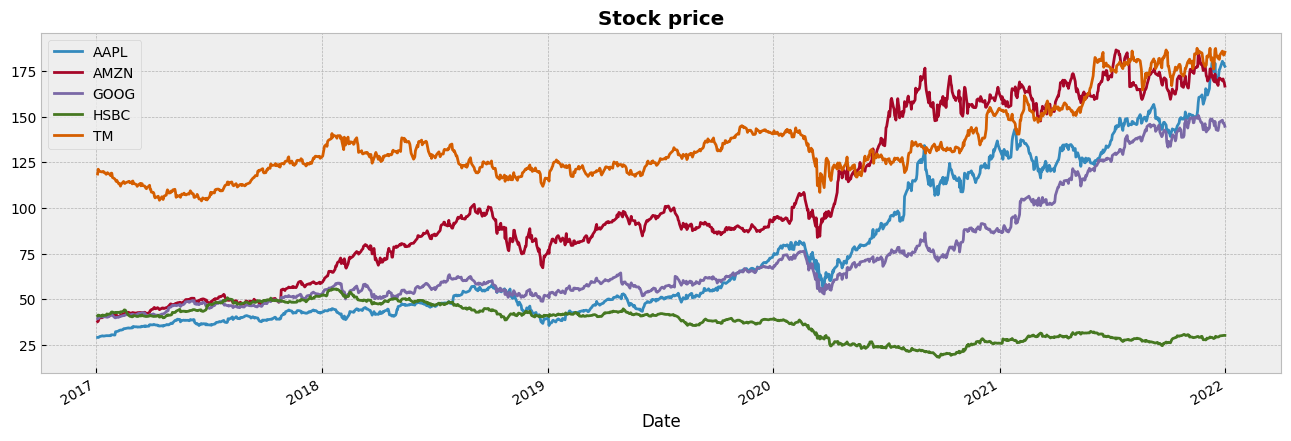

In [ ]:
prices.plot(figsize=(16, 5))
plt.title("Stock price", weight="bold")
plt.show()

Строим графики доходностей

In [ ]:
returns = 100*prices.pct_change().dropna()

returns.head()

,AAPL,AMZN,GOOG,HSBC,TM
Date,,,,,
2017-01-04,-0.111928,0.465728,0.096680,0.953777,2.226908
2017-01-05,0.508536,3.073240,0.904814,-0.290695,-0.618863
2017-01-06,1.114830,1.991160,1.527666,-0.024291,-0.257394
2017-01-09,0.915948,0.116839,0.062027,-1.190770,-0.324648
2017-01-10,0.100851,-0.127999,-0.230589,0.221348,0.016706


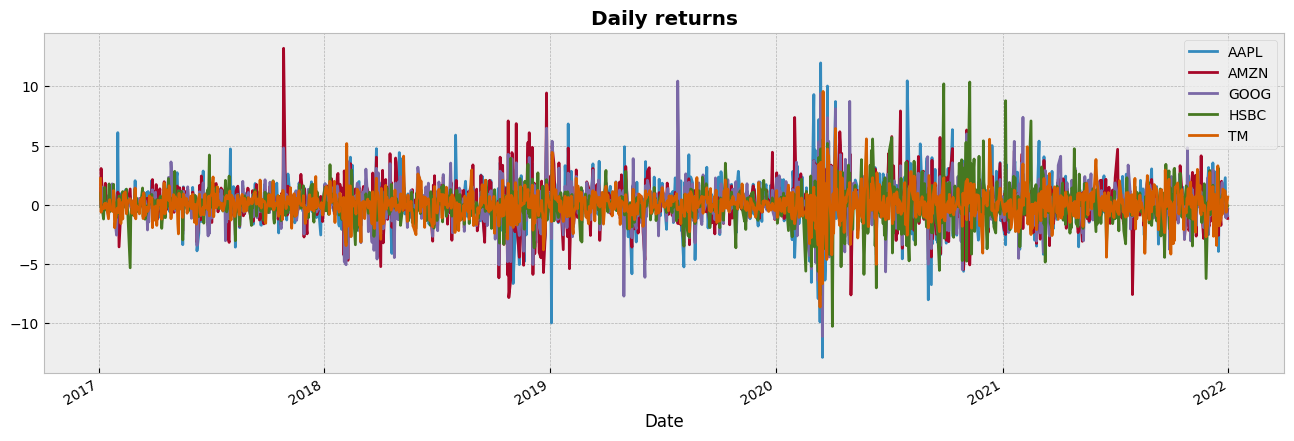

In [ ]:
returns.plot(figsize=(16, 5))
plt.title("Daily returns", weight="bold")
plt.show()

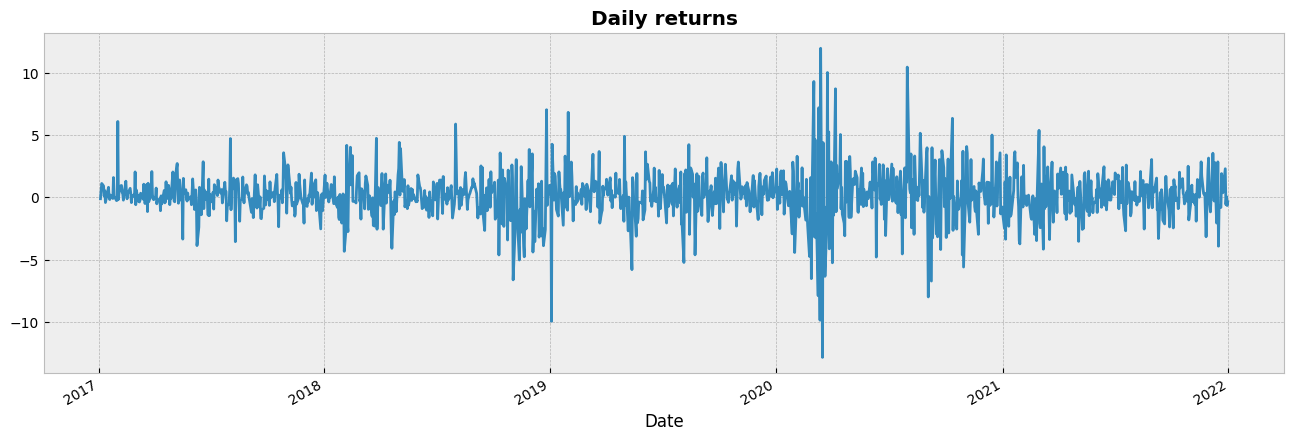

In [ ]:
ret = returns['AAPL']

ret.plot(figsize=(16, 5))
plt.title("Daily returns", weight="bold")
plt.show()

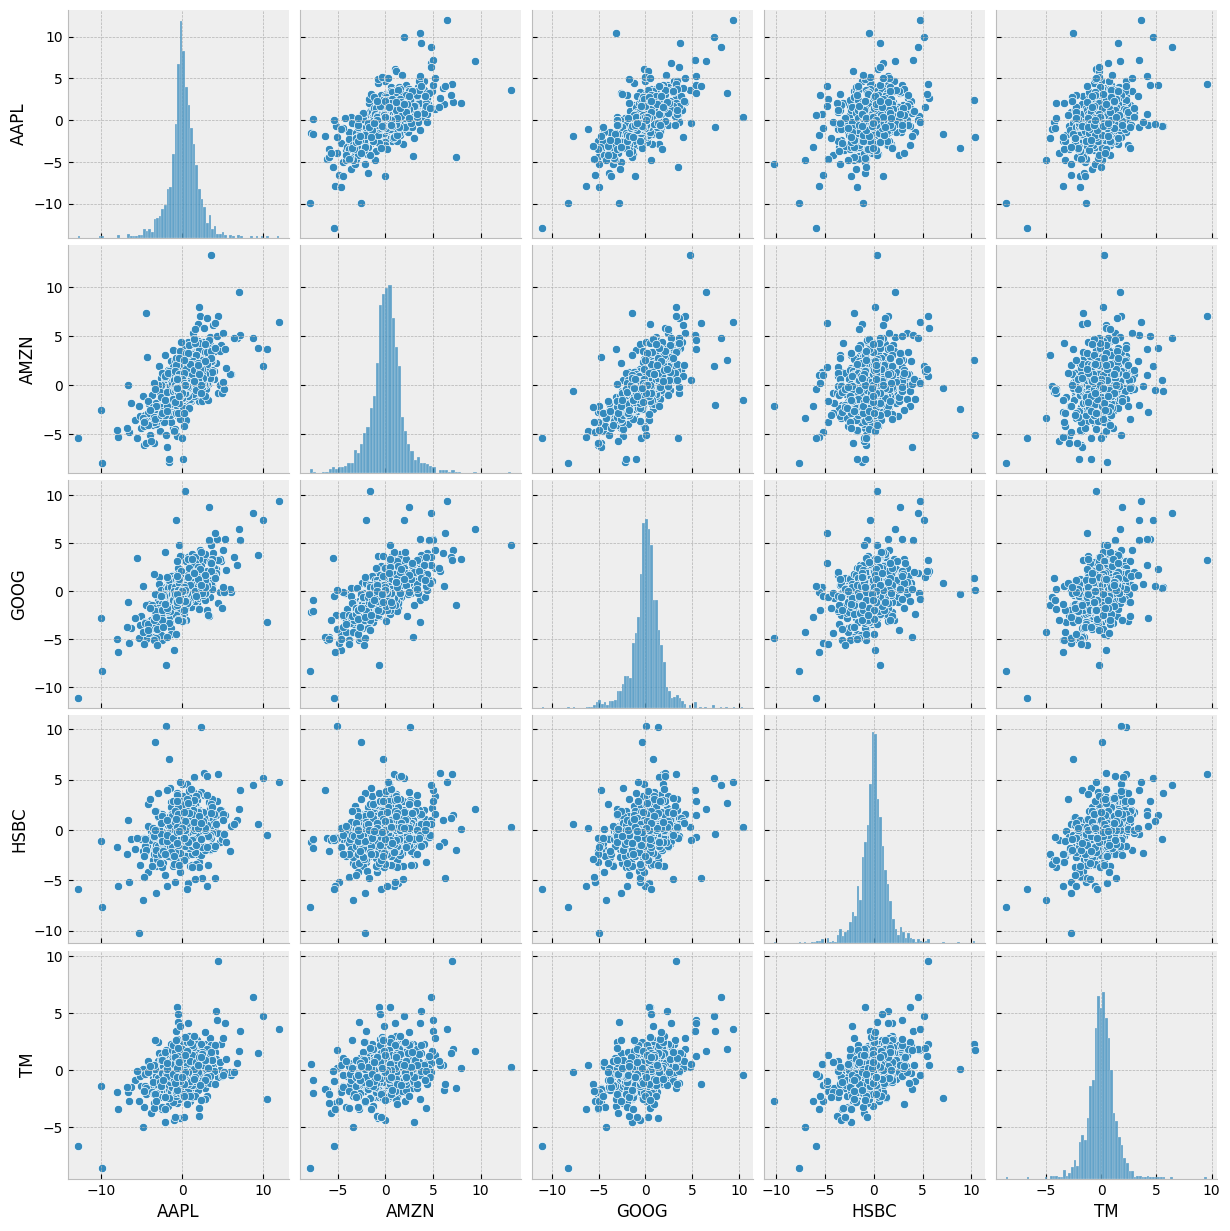

In [ ]:
sns.pairplot(returns)

plt.show()

Возьмем функции для моделирования VaR различными способами с предыдущего семинара

In [ ]:
def calculate_var_HS(returns, alpha):
    
    return returns.quantile(alpha)


def calculate_var_gennorm(returns, alpha):
    beta, loc, scale = scipy.stats.gennorm.fit(returns)
    
    return scipy.stats.gennorm.ppf(alpha, beta, loc, scale)


def calculate_var_garch(returns, alpha):
    
    scaling_const = 10.0 / returns.std()

    dist = 'skewstudent'
    am = arch_model(scaling_const * returns,
                    mean='HARX', lags=1, # mean = Constant, ARX, HARX + the number of lags
                    vol='Garch', p=1, o=1, q=1, # vol = Garch, EGARCH, HARCH + the number of lags
                    dist=dist) # dist = Normal, t, skewstudent, ged

    res = am.fit(update_freq=0, disp='off')

    forecasts = res.forecast(horizon=1, reindex=False)

    cond_mean = float(forecasts.mean.iloc[-1])
    cond_var = float(forecasts.variance.iloc[-1])

    if dist == 'Normal':
        q = am.distribution.ppf(alpha)
    elif dist == 't' or dist == 'ged':
        q = am.distribution.ppf(alpha, res.params[-1:])
    elif dist == 'skewstudent':
        q = am.distribution.ppf(alpha, res.params[-2:])

    return_garch_forecast = cond_mean / scaling_const
    VaR_garch_forecast = (cond_mean + np.sqrt(cond_var) * q) / scaling_const

    return return_garch_forecast, VaR_garch_forecast

In [ ]:
ret = returns['AAPL']

returns.columns

Index(['AAPL', 'AMZN', 'GOOG', 'HSBC', 'TM'], dtype='object')

In [ ]:
alpha = 0.01

T = len(ret)
T_start = 100
estimation_window = 250
testing_window = T - estimation_window

VaR_curve_HS = []
VaR_curve_gennorm = []
VaR_curve_garch = []
forecast_garch = []

for t in range(estimation_window+T_start, T):
    
    current_estimation_sample = ret[t-estimation_window:t]

    VaR_curve_HS.append(calculate_var_HS(current_estimation_sample, alpha))
    VaR_curve_gennorm.append(calculate_var_gennorm(current_estimation_sample, alpha))
    
    return_garch_forecast, VaR_garch_forecast = calculate_var_garch(current_estimation_sample, alpha)
    forecast_garch.append(return_garch_forecast)
    VaR_curve_garch.append(VaR_garch_forecast)
    
VaR_curve_HS = pd.Series(VaR_curve_HS, index=ret[estimation_window+T_start:].index)
VaR_curve_gennorm = pd.Series(VaR_curve_gennorm, index=ret[estimation_window+T_start:].index)
VaR_curve_garch = pd.Series(VaR_curve_garch, index=ret[estimation_window+T_start:].index)
forecast_garch = pd.Series(forecast_garch, index=ret[estimation_window+T_start:].index)

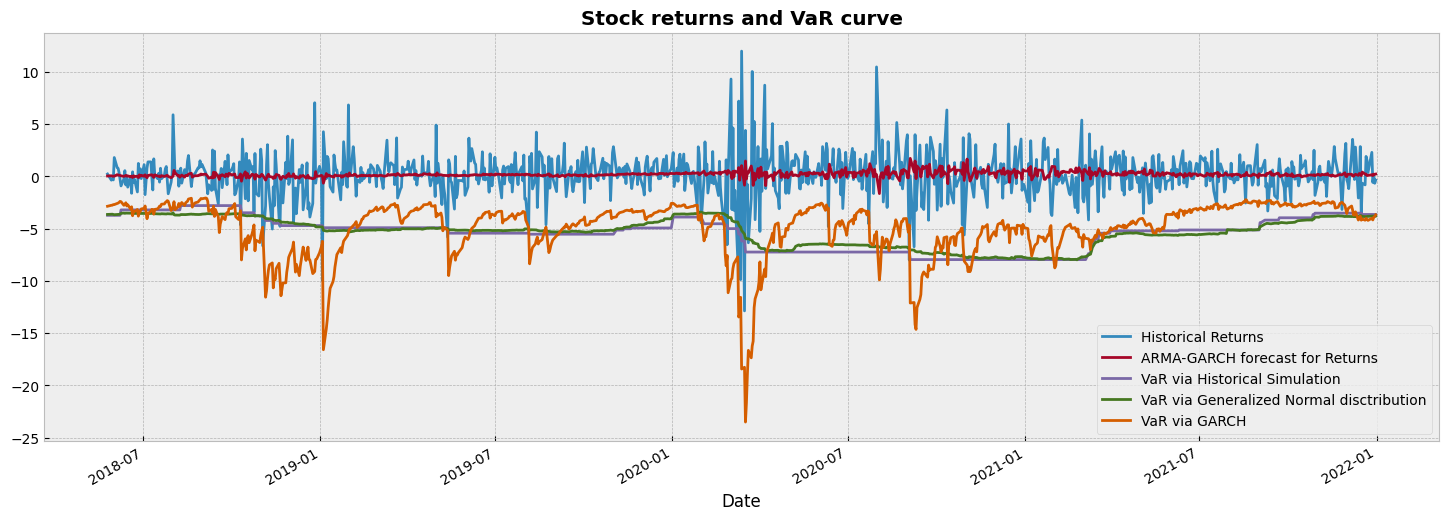

In [ ]:
fig = plt.figure()
fig.set_size_inches(18,6)
ret[estimation_window+T_start:].plot()
forecast_garch.plot()
VaR_curve_HS.plot()
VaR_curve_gennorm.plot()
VaR_curve_garch.plot()

plt.title("Stock returns and VaR curve", weight="bold")

plt.legend(['Historical Returns',
            'ARMA-GARCH forecast for Returns',
            'VaR via Historical Simulation',
            'VaR via Generalized Normal disctribution',
           'VaR via GARCH'])
plt.show()

Таким образом, мы для каждого способа моделирования получили кривую VaR

Вопросы:
- Какой способ подсчета VaR выбрать? 
- Как моделировать доходность портфеля из нескольких активов?

Для выбора подходящей модели будем использовать тест Купика, который сравнивает модельную и реальную частоту пробоев.

[Overview of VaR Backtesting](https://www.mathworks.com/help/risk/overview-of-var-backtesting.html)

In [ ]:
def kupiec_test(VaR_curve, actual_returns, pp=0.1):
    
    T = len(actual_returns)
    K = (actual_returns < VaR_curve).sum()
    alpha_0 = K / T
    
    S = -2*np.log((1-alpha)**(T-K) * alpha**K) + 2*np.log((1-alpha_0)**(T-K) * alpha_0**K)
    p_value = 1 - scipy.stats.chi2.cdf(S, df=1)
        
    if np.isnan(p_value):
        p_value = 0.
        
    print('Количество наблюдений:', T)
    print('Желаемый уровень пробитий: {:.1f}%'.format(alpha*100))
    print('Уровень пробитий в модели: {:.2f}%'.format(alpha_0*100))
        
    print('\np-value теста: {:.3f}'.format(p_value))
    if p_value > pp:
        print("""\nПри уровне значимости {:.0f}% гипотеза гипотеза о
том, что эмпирическая и модельная частоты превышений фактическими
убытками границы VaR равны, НЕ ОТВЕРГАЕТСЯ""".format(pp*100))
    else:
        print("""\nПри уровне значимости {:.1f}% гипотеза гипотеза о
том, что эмпирическая и модельная частоты превышений фактическими
убытками границы VaR равны, отвергается""".format(pp*100))

In [ ]:
kupiec_test(VaR_curve_gennorm, ret[estimation_window+T_start:])

Количество наблюдений: 908
Желаемый уровень пробитий: 1.0%
Уровень пробитий в модели: 1.76%

p-value теста: 0.037

При уровне значимости 10.0% гипотеза гипотеза о
том, что эмпирическая и модельная частоты превышений фактическими
убытками границы VaR равны, отвергается


In [ ]:
kupiec_test(VaR_curve_garch, ret[estimation_window+T_start:])

Количество наблюдений: 908
Желаемый уровень пробитий: 1.0%
Уровень пробитий в модели: 1.76%

p-value теста: 0.037

При уровне значимости 10.0% гипотеза гипотеза о
том, что эмпирическая и модельная частоты превышений фактическими
убытками границы VaR равны, отвергается


--------
Теперь будем моделировать совместное распределение длходностей активов, чтобы подсчитать Value-at-Risk всего портфеля.

Сначала посмотрим на историческое распределение доходностей двух акций

<Figure size 600x600 with 0 Axes>

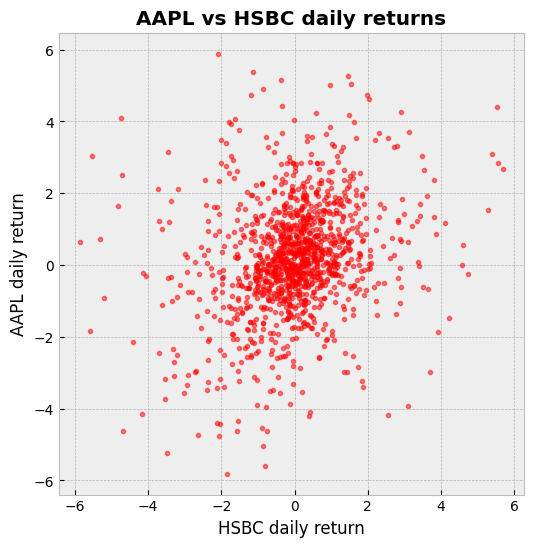

In [ ]:
idx = (returns['HSBC'] > -6) & (returns['HSBC'] < 6)
idx = idx & (returns['AAPL'] > -6) & (returns['AAPL'] < 6)

x = returns.loc[idx, 'HSBC']
y = returns.loc[idx, 'AAPL']

fig = plt.figure()
fig.set_size_inches(6,6)

fig = plt.figure()
fig.set_size_inches(6,6)

plt.plot(x, y, "r.", alpha=0.5)
plt.xlabel("HSBC daily return")
plt.ylabel("AAPL daily return")
plt.title("AAPL vs HSBC daily returns", weight="bold")
plt.show()

Мы можем смоделировать частные распределения с помощью уже известных нам распределений, например Стьюдента

In [ ]:
n_samples = 10 ** 5

return_simulations = {}

# для каждой акции оцениваем одномерное распределение, а потом сэмплируем из него новые псевдо-наблюдения
for col in returns.columns:
    t_df, t_mean, t_sigma = scipy.stats.t.fit(returns[col])
    return_simulations[col] = scipy.stats.t.rvs(t_df, loc=t_mean, scale=t_sigma, size=n_samples, random_state=42)
    
return_simulations = pd.DataFrame(return_simulations)

In [ ]:
return_simulations.head()

,AAPL,AMZN,GOOG,HSBC,TM
0,0.884242,0.867172,0.788929,0.576931,0.563179
1,-1.110654,-1.130322,-0.931823,-0.997630,-0.886011
2,1.693093,1.687704,1.467332,1.189048,1.199205
3,-0.848130,-0.856335,-0.726096,-0.818920,-0.646728
4,1.505440,1.418317,1.476641,1.287255,0.759932


In [ ]:
returns.head()

,AAPL,AMZN,GOOG,HSBC,TM
Date,,,,,
2017-01-04,-0.111928,0.465728,0.096680,0.953777,2.226908
2017-01-05,0.508536,3.073240,0.904814,-0.290695,-0.618863
2017-01-06,1.114830,1.991160,1.527666,-0.024291,-0.257394
2017-01-09,0.915948,0.116839,0.062027,-1.190770,-0.324648
2017-01-10,0.100851,-0.127999,-0.230589,0.221348,0.016706


In [ ]:
np.cov(returns.values, rowvar=False)

array([[3.68414171, 2.25784651, 2.15003351, 0.97857179, 0.99149363],
       [2.25784651, 3.43778933, 2.10389227, 0.68818128, 0.74666286],
       [2.15003351, 2.10389227, 2.89056477, 0.96917996, 0.99840426],
       [0.97857179, 0.68818128, 0.96917996, 2.53313487, 0.94839942],
       [0.99149363, 0.74666286, 0.99840426, 0.94839942, 1.61259858]])

In [ ]:
np.cov(return_simulations.values, rowvar=False)

array([[ 4.49739142e+00,  7.67749569e-02,  5.89470144e-03,
        -1.27840777e-02,  4.99644276e-03],
       [ 7.67749569e-02,  4.18559425e+00,  9.12394981e-03,
         2.70645873e-03, -3.07127247e-03],
       [ 5.89470144e-03,  9.12394981e-03,  4.43727680e+00,
         7.72780620e-02, -6.90971084e-04],
       [-1.27840777e-02,  2.70645873e-03,  7.72780620e-02,
         3.87916230e+00,  8.65679738e-03],
       [ 4.99644276e-03, -3.07127247e-03, -6.90971084e-04,
         8.65679738e-03,  1.65928105e+00]])

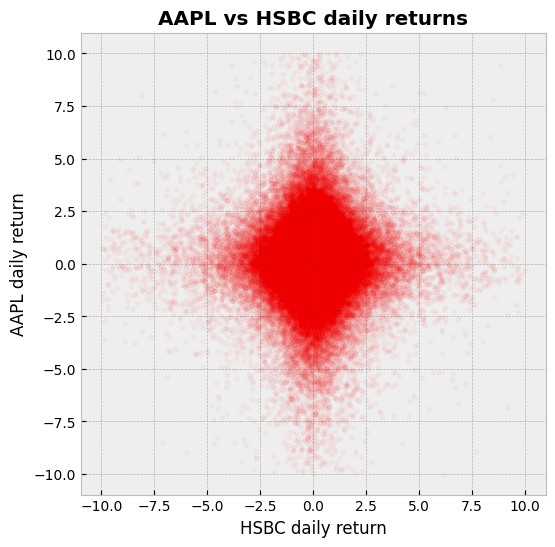

In [ ]:
idx = (return_simulations['HSBC'] > -10) & (return_simulations['HSBC'] < 10)
idx = idx & (return_simulations['AAPL'] > -10) & (return_simulations['AAPL'] < 10)

x = return_simulations.loc[idx, 'HSBC']
y = return_simulations.loc[idx, 'AAPL']

fig = plt.figure()
fig.set_size_inches(6,6)

plt.plot(x, y, "r.", alpha=0.03)
plt.xlabel("HSBC daily return")
plt.ylabel("AAPL daily return")
plt.title("AAPL vs HSBC daily returns", weight="bold")
plt.show()

In [ ]:
w = np.ones(shape=(returns.shape[1],)) / returns.shape[1]

# w = 1 / prices.iloc[0]
# w = w / w.sum()
portfolio_real_returns = np.dot(returns.values, w)

print(w)
portfolio_real_returns

[0.2 0.2 0.2 0.2 0.2]


array([ 0.72623298,  0.71540642,  0.87039415, ..., -0.22273975,
       -0.25541063, -0.36123073])

<ipython-input-25-6787bc281504>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(portfolio_real_returns, hist=True, kde=False,


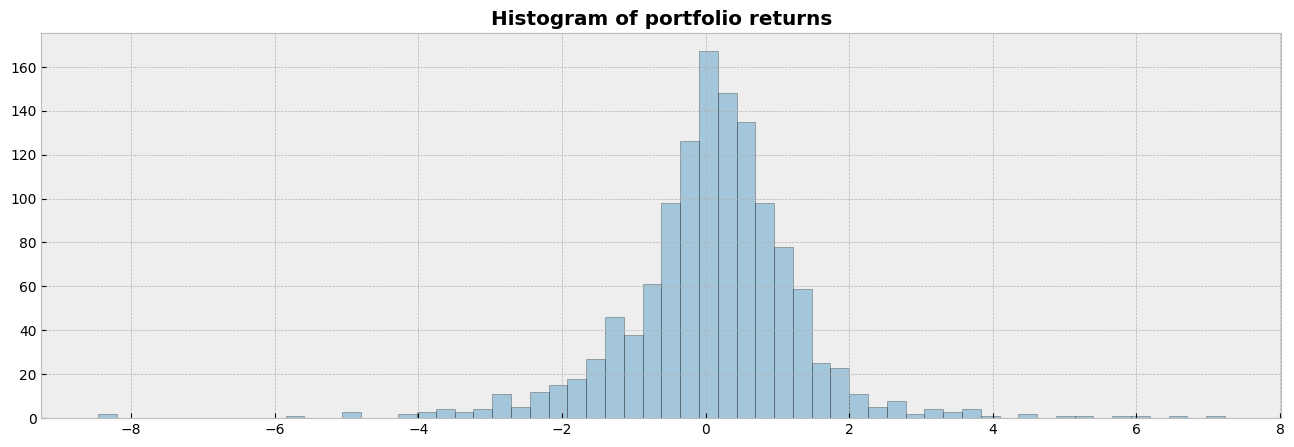

In [ ]:
fig = plt.figure(figsize=(16, 5))

sns.distplot(portfolio_real_returns, hist=True, kde=False, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.title("Histogram of portfolio returns", weight="bold")

plt.show()

## Произведение одномерных распределений

Попробуем смоделировать доходности каждого актива отделььно и затем перейти к доходности портфеля с равномерными весами

In [ ]:
import scipy.stats as ss

In [ ]:
n_samples = 10 ** 4

return_simulations = {}

# для каждой акции оцениваем одномерное распределение, а потом сэмплируем из него новые псевдо-наблюдения
for col in returns.columns:
    t_df, t_mean, t_sigma = ss.t.fit(returns[col])
    return_simulations[col] = ss.t.rvs(t_df, loc=t_mean, scale=t_sigma, size=n_samples, random_state=42)
    
return_simulations = pd.DataFrame(return_simulations)

return_simulations.shape

(10000, 5)

<ipython-input-28-0dd29837d111>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(portfolio_real_returns, hist=True, kde=True,
<ipython-input-28-0dd29837d111>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(portfolio_simulated_returns, hist=True, kde=True,


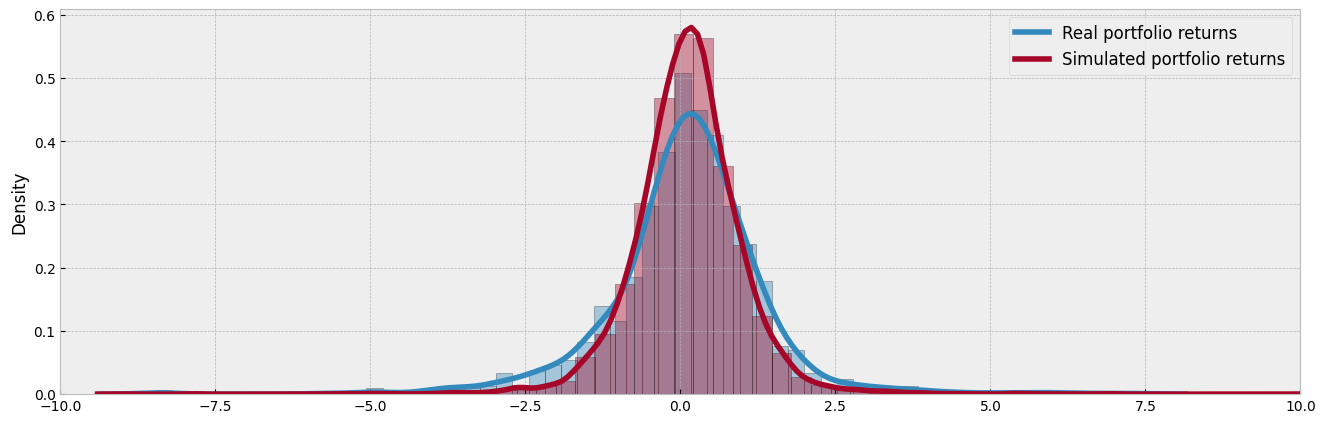

In [ ]:
portfolio_simulated_returns = np.dot(return_simulations.values, w)

fig = plt.figure(figsize=(16, 5))

sns.distplot(portfolio_real_returns, hist=True, kde=True, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

sns.distplot(portfolio_simulated_returns, hist=True, kde=True, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.xlim((-10, 10))

plt.legend(['Real portfolio returns',
            'Simulated portfolio returns'], fontsize=12)
plt.show()

Однако здесь никак не учитываются корреляции между активами.

## Многомерные распределения

Один из способов это сделать -- использовать многомерные распределения, например, многомерное нормальное распределение

In [ ]:
n_samples = 10 ** 5

# оцениваем параметры нормального распределения распределение
mean = np.mean(returns.values, axis=0)
cov = np.cov(returns.values, rowvar=False)

# а потом сэмплируем из него новые псевдо-наблюдения
return_simulations = scipy.stats.multivariate_normal.rvs(mean=mean, cov=cov, size=n_samples, random_state=42)

return_simulations = pd.DataFrame(return_simulations, columns=returns.columns)

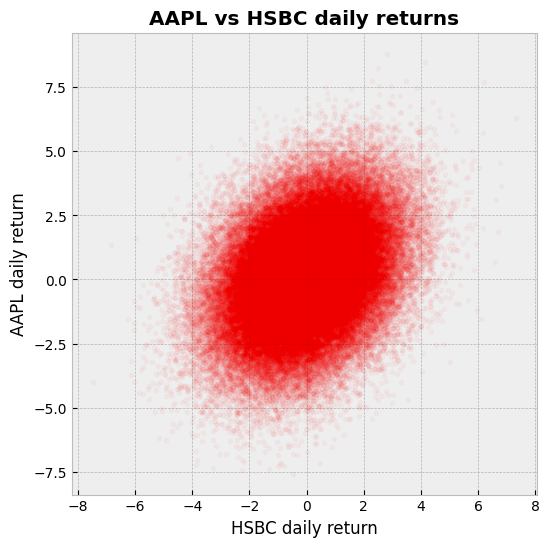

In [ ]:
idx = (return_simulations['HSBC'] > -10) & (return_simulations['HSBC'] < 10)
idx = idx & (return_simulations['AAPL'] > -10) & (return_simulations['AAPL'] < 10)

x = return_simulations.loc[idx, 'HSBC']
y = return_simulations.loc[idx, 'AAPL']

fig = plt.figure()
fig.set_size_inches(6,6)

plt.plot(x, y, "r.", alpha=0.03)
plt.xlabel("HSBC daily return")
plt.ylabel("AAPL daily return")
plt.title("AAPL vs HSBC daily returns", weight="bold")
plt.show()

Посчитаем VaR для портфеля с одинаковыми весами

In [ ]:
w = np.ones(shape=(returns.shape[1],)) / 5
w

array([0.2, 0.2, 0.2, 0.2, 0.2])

In [ ]:
alpha = 0.05

In [ ]:
# умножаем матрицу псевдо-наблюдений на вектор весов и получаем псевдо-наблюдения доходностей портфеля

portfolio_real_returns = np.dot(returns.values, w)
portfolio_simulated_returns = np.dot(return_simulations.values, w)

print(np.quantile(portfolio_real_returns, alpha))
print(np.quantile(portfolio_simulated_returns, alpha))

-1.9569083415234032
-1.9934741473109188


Эмпирическая квантиль и квантиль многомерного нормального распределения похожи. Посмотрим на гистограмму распределения доходностей портфеля

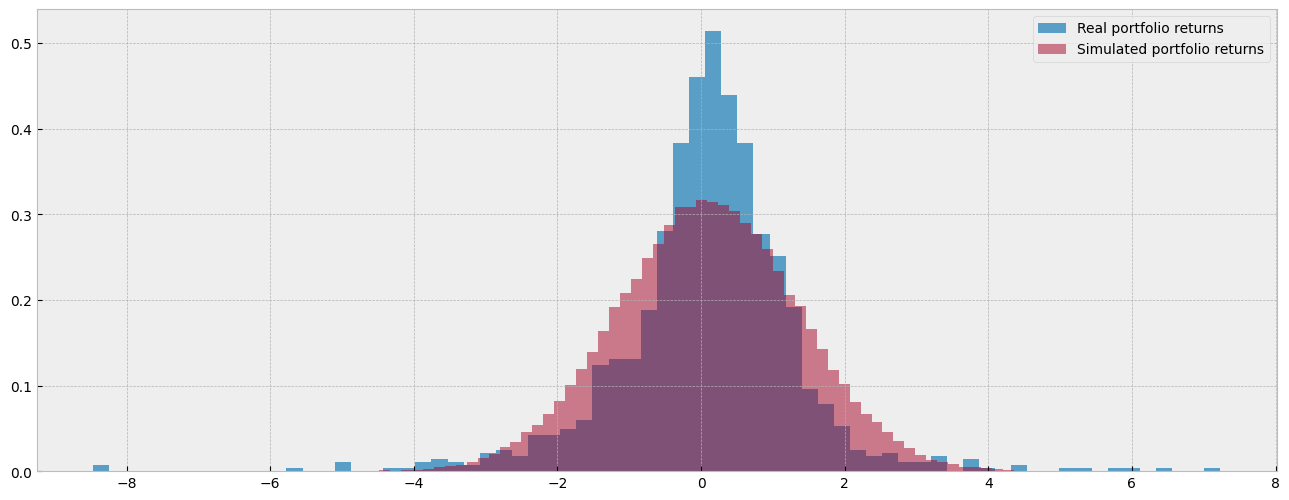

In [ ]:
fig = plt.figure()
fig.set_size_inches(16,6)

plt.hist(portfolio_real_returns, bins=70, density=True, alpha=0.8, label='Real portfolio returns')
plt.hist(portfolio_simulated_returns, bins=70, density=True, alpha=0.5, label='Simulated portfolio returns')
plt.legend(loc='upper right')

Распределения сильно отличаются.

## Копулы

[Документация](https://copulae.readthedocs.io/en/latest/getting-started.html)

In [ ]:
from copulae import NormalCopula, GaussianCopula, StudentCopula, ClaytonCopula, FrankCopula, GumbelCopula

Сначала моделируем частные распределения активов, например, с помощью распределения Стьюдента

In [ ]:
cdfs = returns.copy()
distribution_params = {}

for col in cdfs.columns:
    t_df, t_mean, t_sigma = scipy.stats.t.fit(cdfs[col])
    distribution_params[col] = (t_df, t_mean, t_sigma)
    cdfs[col] = scipy.stats.t.cdf(cdfs[col], df=t_df, loc=t_mean, scale=t_sigma)

In [ ]:
cdfs

,AAPL,AMZN,GOOG,HSBC,TM
Date,,,,,
2017-01-04,0.411691,0.594574,0.472590,0.805749,0.963542
2017-01-05,0.602817,0.954699,0.738363,0.383011,0.241959
2017-01-06,0.758598,0.890884,0.860286,0.486094,0.368641
2017-01-09,0.713465,0.487064,0.460063,0.146533,0.342547
2017-01-10,0.477123,0.411766,0.358723,0.582821,0.482587
...,...,...,...,...,...
2021-12-27,0.914042,0.234064,0.657809,0.734978,0.859123
2021-12-28,0.284406,0.629307,0.153166,0.599825,0.242036
2021-12-29,0.461349,0.226402,0.451623,0.586965,0.254112


In [ ]:
returns

,AAPL,AMZN,GOOG,HSBC,TM
Date,,,,,
2017-01-04,-0.111928,0.465728,0.096680,0.953777,2.226908
2017-01-05,0.508536,3.073240,0.904814,-0.290695,-0.618863
2017-01-06,1.114830,1.991160,1.527666,-0.024291,-0.257394
2017-01-09,0.915948,0.116839,0.062027,-1.190770,-0.324648
2017-01-10,0.100851,-0.127999,-0.230589,0.221348,0.016706
...,...,...,...,...,...
2021-12-27,2.297483,-0.817802,0.626259,0.669564,1.153551
2021-12-28,-0.576725,0.584372,-1.091418,0.266046,-0.618609
2021-12-29,0.050204,-0.855492,0.038582,0.232171,-0.579165


In [ ]:
distribution_params

{'AAPL': (2.847361407739341, 0.1740101819264247, 1.1693990034685484),
 'AMZN': (2.954727063203909, 0.15827501634111973, 1.1755973930638195),
 'GOOG': (2.6422813245579464, 0.17214665678072888, 0.9998975641664347),
 'HSBC': (2.551185776045555, 0.010664825658663281, 0.9108673352483645),
 'TM': (3.6587283657015917, 0.05732430704821952, 0.8693973426353463)}

Посмотрим как выглядят доходности и распределение их квантилей

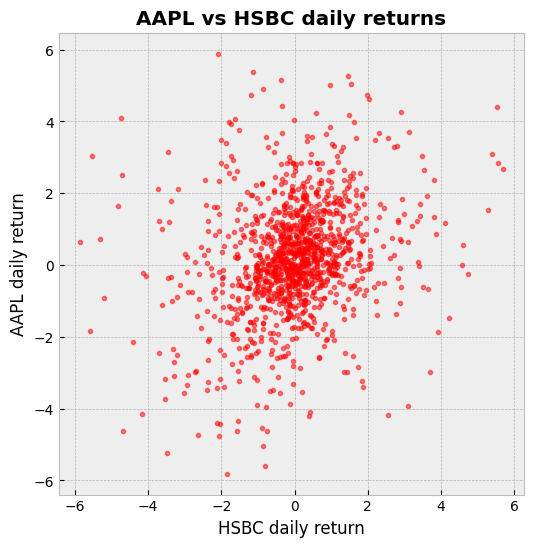

In [ ]:
idx = (returns['HSBC'] > -6) & (returns['HSBC'] < 6)
idx = idx & (returns['AAPL'] > -6) & (returns['AAPL'] < 6)

x = returns.loc[idx, 'HSBC']
y = returns.loc[idx, 'AAPL']

fig = plt.figure()
fig.set_size_inches(6,6)

plt.plot(x, y, "r.", alpha=0.5)
plt.xlabel("HSBC daily return")
plt.ylabel("AAPL daily return")
plt.title("AAPL vs HSBC daily returns", weight="bold")
plt.show()

Распределение их квантилей

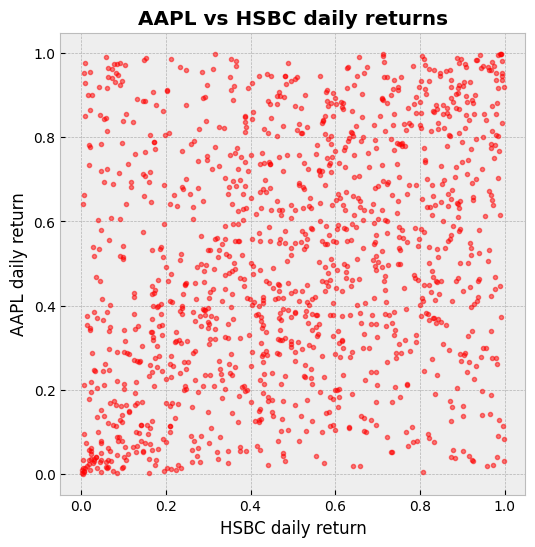

In [ ]:
x = cdfs['HSBC']
y = cdfs['AAPL']

fig = plt.figure()
fig.set_size_inches(6,6)

plt.plot(x, y, "r.", alpha=0.5)
plt.xlabel("HSBC daily return")
plt.ylabel("AAPL daily return")
plt.title("AAPL vs HSBC daily returns", weight="bold")
plt.show()

In [ ]:
returns.head()

,AAPL,AMZN,GOOG,HSBC,TM
Date,,,,,
2017-01-04,-0.111928,0.465728,0.096680,0.953777,2.226908
2017-01-05,0.508536,3.073240,0.904814,-0.290695,-0.618863
2017-01-06,1.114830,1.991160,1.527666,-0.024291,-0.257394
2017-01-09,0.915948,0.116839,0.062027,-1.190770,-0.324648
2017-01-10,0.100851,-0.127999,-0.230589,0.221348,0.016706


In [ ]:
cdfs.head()

,AAPL,AMZN,GOOG,HSBC,TM
Date,,,,,
2017-01-04,0.411691,0.594574,0.472590,0.805749,0.963542
2017-01-05,0.602817,0.954699,0.738363,0.383011,0.241959
2017-01-06,0.758598,0.890884,0.860286,0.486094,0.368641
2017-01-09,0.713465,0.487064,0.460063,0.146533,0.342547
2017-01-10,0.477123,0.411766,0.358723,0.582821,0.482587


Используем разные копулы

Оценим Нормальную копулу и посмотрим на ее описание

In [ ]:
cop = NormalCopula(dim=5)
cop.fit(cdfs)

              AAPL         AMZN         GOOG         HSBC           TM
count  1258.000000  1258.000000  1258.000000  1258.000000  1258.000000
mean      0.500000     0.500000     0.500000     0.500000     0.500000
std       0.288560     0.288560     0.288560     0.288560     0.288560
min       0.000794     0.000794     0.000794     0.000794     0.000794
25%       0.250397     0.250397     0.250397     0.250397     0.250397
50%       0.500000     0.500000     0.500000     0.497617     0.500000
75%       0.749603     0.749603     0.749603     0.749603     0.749603
max       0.999206     0.999206     0.999206     0.999206     0.999206


In [ ]:
cop.summary()

1.000000,0.640816,0.639342,0.307154,0.370822
0.640816,1.000000,0.685855,0.239326,0.298602
0.639342,0.685855,1.000000,0.346408,0.429605
0.307154,0.239326,0.346408,1.000000,0.455891
0.370822,0.298602,0.429605,0.455891,1.000000


In [ ]:
cop2 = StudentCopula(dim=5)
cop2.fit(cdfs)

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


              AAPL         AMZN         GOOG         HSBC           TM
count  1258.000000  1258.000000  1258.000000  1258.000000  1258.000000
mean      0.500000     0.500000     0.500000     0.500000     0.500000
std       0.288560     0.288560     0.288560     0.288560     0.288560
min       0.000794     0.000794     0.000794     0.000794     0.000794
25%       0.250397     0.250397     0.250397     0.250397     0.250397
50%       0.500000     0.500000     0.500000     0.497617     0.500000
75%       0.749603     0.749603     0.749603     0.749603     0.749603
max       0.999206     0.999206     0.999206     0.999206     0.999206


In [ ]:
cop2.summary()

1.000000,0.641607,0.660036,0.322749,0.370850
0.641607,1.000000,0.711488,0.237974,0.304919
0.660036,0.711488,1.000000,0.343512,0.412053
0.322749,0.237974,0.343512,1.000000,0.433480
0.370850,0.304919,0.412053,0.433480,1.000000


In [ ]:
cop3 =  ClaytonCopula(dim=5)
cop3.fit(cdfs)
cop3.summary()

              AAPL         AMZN         GOOG         HSBC           TM
count  1258.000000  1258.000000  1258.000000  1258.000000  1258.000000
mean      0.500000     0.500000     0.500000     0.500000     0.500000
std       0.288560     0.288560     0.288560     0.288560     0.288560
min       0.000794     0.000794     0.000794     0.000794     0.000794
25%       0.250397     0.250397     0.250397     0.250397     0.250397
50%       0.500000     0.500000     0.500000     0.497617     0.500000
75%       0.749603     0.749603     0.749603     0.749603     0.749603
max       0.999206     0.999206     0.999206     0.999206     0.999206


Clayton Copula Summary
================================================================================
Clayton Copula with 5 dimensions


Parameters
--------------------------------------------------------------------------------
       theta        : 0.6245000590717962

In [ ]:
cop4 =  FrankCopula(dim=5)
cop4.fit(cdfs)
cop4.summary()

              AAPL         AMZN         GOOG         HSBC           TM
count  1258.000000  1258.000000  1258.000000  1258.000000  1258.000000
mean      0.500000     0.500000     0.500000     0.500000     0.500000
std       0.288560     0.288560     0.288560     0.288560     0.288560
min       0.000794     0.000794     0.000794     0.000794     0.000794
25%       0.250397     0.250397     0.250397     0.250397     0.250397
50%       0.500000     0.500000     0.500000     0.497617     0.500000
75%       0.749603     0.749603     0.749603     0.749603     0.749603
max       0.999206     0.999206     0.999206     0.999206     0.999206


Frank Copula Summary
================================================================================
Frank Copula with 5 dimensions


Parameters
--------------------------------------------------------------------------------
       theta        : 2.723284846349152

In [ ]:
cop5 =  GumbelCopula(dim=5)
cop5.fit(cdfs)
cop5.summary()

              AAPL         AMZN         GOOG         HSBC           TM
count  1258.000000  1258.000000  1258.000000  1258.000000  1258.000000
mean      0.500000     0.500000     0.500000     0.500000     0.500000
std       0.288560     0.288560     0.288560     0.288560     0.288560
min       0.000794     0.000794     0.000794     0.000794     0.000794
25%       0.250397     0.250397     0.250397     0.250397     0.250397
50%       0.500000     0.500000     0.500000     0.497617     0.500000
75%       0.749603     0.749603     0.749603     0.749603     0.749603
max       0.999206     0.999206     0.999206     0.999206     0.999206


Gumbel Copula Summary
================================================================================
Gumbel Copula with 5 dimensions


Parameters
--------------------------------------------------------------------------------
       theta        : 1.3658864149237977

Теперь мы можем сэмплировать частные квантили с помощью оцененной копулы, и можем построить их распределение

In [ ]:
cop_arr=[cop, cop2, cop3, cop4, cop5]

In [ ]:
n_samples = 10 ** 5
#copula_simulations=[]
#for cop in cop_arr:
copula_simulations_tmp = cop.random(n_samples, seed=42)
copula_simulations=(pd.DataFrame(copula_simulations_tmp, columns=cdfs.columns))

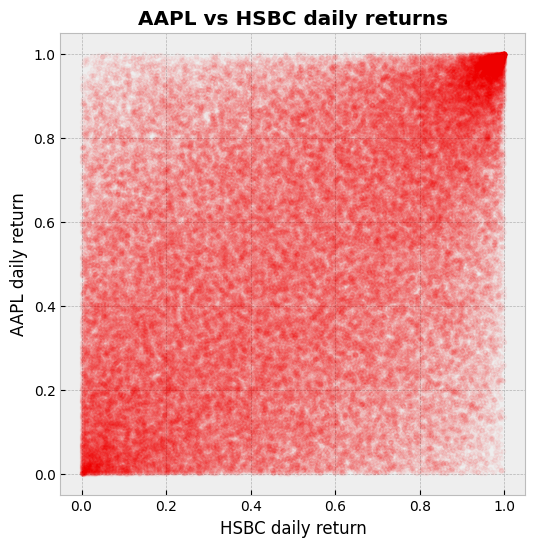

In [ ]:
x = copula_simulations['HSBC']
y = copula_simulations['AAPL']

fig = plt.figure()
fig.set_size_inches(6,6)

plt.plot(x, y, "r.", alpha=0.03)
plt.xlabel("HSBC daily return")
plt.ylabel("AAPL daily return")
plt.title("AAPL vs HSBC daily returns", weight="bold")
plt.show()

Теперь вернемся от квантилей к доходностям с помощью inverse CDF и посмотрим на распределение сэмплов

In [ ]:
return_simulations = copula_simulations.copy()

for col in cdfs.columns:
    t_df, t_mean, t_sigma = distribution_params[col]
    return_simulations[col] = scipy.stats.t.ppf(copula_simulations[col], df=t_df, loc=t_mean, scale=t_sigma)

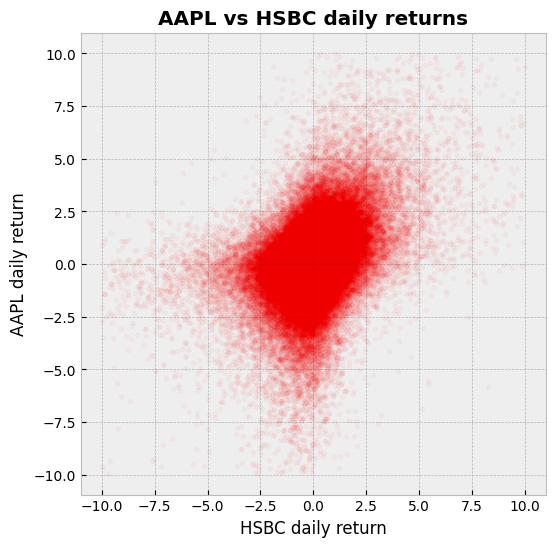

In [ ]:
idx = (return_simulations['HSBC'] > -10) & (return_simulations['HSBC'] < 10)
idx = idx & (return_simulations['AAPL'] > -10) & (return_simulations['AAPL'] < 10)

x = return_simulations.loc[idx, 'HSBC']
y = return_simulations.loc[idx, 'AAPL']

fig = plt.figure()
fig.set_size_inches(6,6)

# fft_axes = fig.add_subplot(212)

plt.plot(x, y, "r.", alpha=0.03)
plt.xlabel("HSBC daily return")
plt.ylabel("AAPL daily return")
plt.title("AAPL vs HSBC daily returns", weight="bold")
plt.show()

Зависимость нелинейная. Посчитаем квантиль в данном случае, а затем посмотрим на гистограммы

In [ ]:
portfolio_real_returns = np.dot(returns.values, w)
portfolio_simulated_returns = np.dot(return_simulations.values, w)

print(np.quantile(portfolio_real_returns, alpha))
print(np.quantile(portfolio_simulated_returns, alpha))

-1.9569083415234032
-1.633685248547287


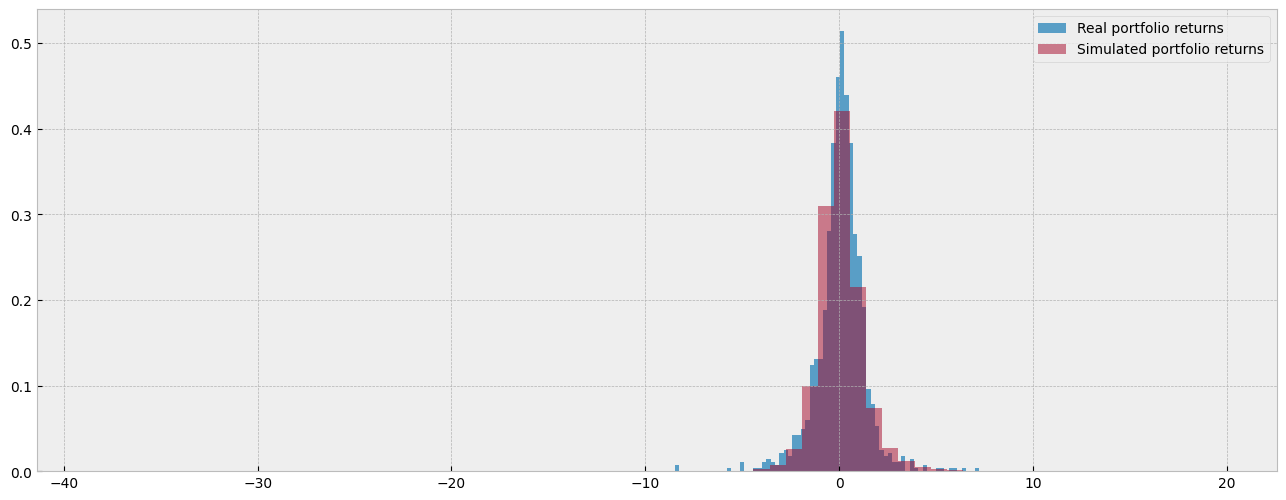

In [ ]:
fig = plt.figure()
fig.set_size_inches(16,6)

plt.hist(portfolio_real_returns, bins=70, density=True, alpha=0.8, label='Real portfolio returns')
plt.hist(portfolio_simulated_returns[idx], bins=70, density=True, alpha=0.5, label='Simulated portfolio returns')
plt.legend(loc='upper right')
plt.show()

Выглядит лучше! Но мы и на этом не остановимся.


**Во-вервых**, можно использовать другие копулы и другие частные распределения

In [ ]:
from copulae import ClaytonCopula, FrankCopula, GumbelCopula

ClaytonCopula

In [ ]:
univariate_dist = 'gennorm' # gennorm
#cop = ClaytonCopula(dim=cdfs.shape[1])
n_samples = 10 ** 5

cdfs = returns.copy()
distribution_params = {}

for col in cdfs.columns:
    if univariate_dist == 't':
        t_df, t_mean, t_sigma = scipy.stats.t.fit(cdfs[col])
        distribution_params[col] = (t_df, t_mean, t_sigma)
        cdfs[col] = scipy.stats.t.cdf(cdfs[col], df=t_df, loc=t_mean, scale=t_sigma)
    else:
        beta, loc, scale = scipy.stats.gennorm.fit(cdfs[col])
        distribution_params[col] = (beta, loc, scale)
        cdfs[col] = scipy.stats.gennorm.cdf(cdfs[col], beta, loc, scale)

#cop.fit(cdfs)

copula_simulations = cop2.random(n_samples, seed=42)
copula_simulations = pd.DataFrame(copula_simulations, columns=cdfs.columns)

return_simulations = copula_simulations.copy()

for col in cdfs.columns:
    if univariate_dist == 't':
        t_df, t_mean, t_sigma = distribution_params[col]
        return_simulations[col] = scipy.stats.t.ppf(copula_simulations[col], df=t_df, loc=t_mean, scale=t_sigma)
    else:
        beta, loc, scale = distribution_params[col]
        return_simulations[col] = scipy.stats.gennorm.ppf(copula_simulations[col], beta, loc, scale)

In [ ]:
portfolio_real_returns = np.dot(returns.values, w)
portfolio_simulated_returns = np.dot(return_simulations.values, w)

print(np.quantile(portfolio_real_returns, alpha))
print(np.quantile(portfolio_simulated_returns, alpha))

-1.9569083415234032
-1.8466457061641728


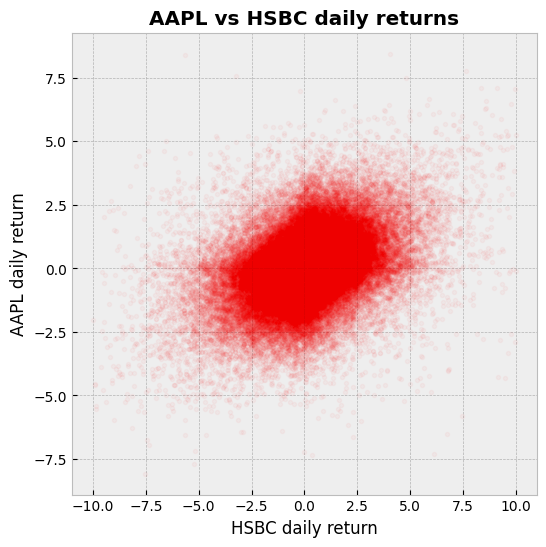

In [ ]:
idx = (return_simulations['HSBC'] > -10) & (return_simulations['HSBC'] < 10)
idx = idx & (return_simulations['AAPL'] > -10) & (return_simulations['AAPL'] < 10)

x = return_simulations.loc[idx, 'AAPL']
y = return_simulations.loc[idx, 'TM']

fig = plt.figure()
fig.set_size_inches(6,6)

# fft_axes = fig.add_subplot(212)

plt.plot(x, y, "r.", alpha=0.03)
plt.xlabel("HSBC daily return")
plt.ylabel("AAPL daily return")
plt.title("AAPL vs HSBC daily returns", weight="bold")
plt.show()

Получилась другая зависимость

**Во-вторых**, можно использовать ARMA-GARCH для учета временной структуры доходностей

Для удобства напишем нужные нам функции

In [ ]:
from arch import arch_model 

In [ ]:
ret = returns.dropna()
dist = 'skewstudent'

def get_garch_residuals(ret, dist, count_lag):

    scaling_const = 10.0 / ret.std()

    # объявляем GARCH модель
    am = arch_model(ret * scaling_const,
                    mean='HARX', lags=1, # mean = Constant, ARX, HARX + the number of lags
                    vol='Garch', p=1, o=count_lag, q=1, # vol = Garch, EGARCH, HARCH + the number of lags
                    dist=dist) # dist = Normal, t, skewstudent, ged

    # фитим модель на данных
    res = am.fit(update_freq=0, disp='off')


    # сохраняем ее распределение
    if dist == 'Normal':
        cdf = am.distribution.cdf(res.resid.dropna())
    elif dist == 't' or dist == 'ged':
        cdf = am.distribution.cdf(res.resid.dropna(), res.params[-1:])
    elif dist == 'skewstudent':
        cdf = am.distribution.cdf(res.resid, res.params[-2:])

        
    return cdf, am, res, scaling_const


def make_garch_forecast(copula_simulation, dist, garch_object, garch_model, scaling_const, count_lag):
    
    # делаем прогноз среднего и дисперсии
    forecasts = garch_object.forecast(horizon=1, reindex=False)

    cond_mean = float(forecasts.mean.iloc[-1])
    cond_var = float(forecasts.variance.iloc[-1])

    # получаем из сэплов квантили сэмплы доходностей
    if dist == 'Normal':
        q = garch_model.distribution.ppf(copula_simulation)
    elif dist == 't' or dist == 'ged':
        q = garch_model.distribution.ppf(copula_simulation, garch_object.params[-1:])
    elif dist == 'skewstudent':
        q = garch_model.distribution.ppf(copula_simulation, garch_object.params[-2:])

    # и по формуле считаем ВаР
    return (cond_mean + np.sqrt(cond_var) * q) / scaling_const

In [ ]:
def make_copula_simulation(returns, copula_func, n_samples, univariate_dist, count_lag, dist='skewstudent'):

    # объявляем копулу
    cop = copula_func(dim=returns.shape[1])

    cdfs = returns.copy()
    distribution_params = {}

    # моделируем частные распределения для каждой акции
    for col in cdfs.columns:
        if univariate_dist == 't':
            t_df, t_mean, t_sigma = scipy.stats.t.fit(returns[col])
            distribution_params[col] = (t_df, t_mean, t_sigma)
            cdfs[col] = scipy.stats.t.cdf(cdfs[col], df=t_df, loc=t_mean, scale=t_sigma)

        elif univariate_dist == 'gennorm':
            beta, loc, scale = scipy.stats.gennorm.fit(returns[col])
            distribution_params[col] = (beta, loc, scale)
            cdfs[col] = scipy.stats.gennorm.cdf(cdfs[col], beta, loc, scale)

        elif univariate_dist == 'garch':
            cdf, am, res, scaling_const= get_garch_residuals(returns[col], dist, count_lag)
            distribution_params[col] = (am, res)
            cdfs[col] = cdf


    # фитим копулу
    cop.fit(cdfs[1:])
    print("!!!")
    # делаем сэмплирование квантилей из совместного распределения копулы
    copula_simulations = cop.random(n_samples, seed=42)
    copula_simulations = pd.DataFrame(copula_simulations, columns=cdfs.columns)

    return_simulations = copula_simulations.copy()

    # трансформируем квантили в доходности с помощью частных функций распределений из первого шага
    for col in cdfs.columns:
        if univariate_dist == 't':
            t_df, t_mean, t_sigma = distribution_params[col]
            return_simulations[col] = scipy.stats.t.ppf(copula_simulations[col], df=t_df, loc=t_mean, scale=t_sigma)

        elif univariate_dist == 'gennorm':
            beta, loc, scale = distribution_params[col]
            return_simulations[col] = scipy.stats.gennorm.ppf(copula_simulations[col], beta, loc, scale)

        elif univariate_dist == 'garch':
            am, res = distribution_params[col]
            return_simulations[col] = make_garch_forecast(copula_simulations[col], dist, res, am, scaling_const, count_lag)
            
    # возвращаем матрицу сэмплированных доходностей
    return return_simulations

Посмотрим, как можно использовать все эти замечательные функции

In [ ]:
return_simulations1 = make_copula_simulation(returns, ClaytonCopula, n_samples=10**5, univariate_dist='garch', count_lag=0)
return_simulations2 = make_copula_simulation(returns, ClaytonCopula, n_samples=10**5, univariate_dist='garch', count_lag=1)

print(return_simulations1, return_simulations2, sep='\n' )

              AAPL         AMZN         GOOG         HSBC           TM
count  1257.000000  1257.000000  1257.000000  1257.000000  1257.000000
mean      0.500000     0.500000     0.500000     0.500000     0.500000
std       0.288560     0.288560     0.288560     0.288560     0.288560
min       0.000795     0.000795     0.000795     0.000795     0.000795
25%       0.250397     0.250397     0.250397     0.250397     0.250397
50%       0.500000     0.500000     0.500000     0.498013     0.500000
75%       0.749603     0.749603     0.749603     0.749603     0.749603
max       0.999205     0.999205     0.999205     0.999205     0.999205
!!!
              AAPL         AMZN         GOOG         HSBC           TM
count  1257.000000  1257.000000  1257.000000  1257.000000  1257.000000
mean      0.500000     0.500000     0.500000     0.500000     0.500000
std       0.288560     0.288560     0.288560     0.288560     0.288560
min       0.000795     0.000795     0.000795     0.000795     0.000795
25

In [ ]:
return_simulations3 = make_copula_simulation(returns, GaussianCopula, n_samples=10**5, univariate_dist='garch', count_lag=0)
return_simulations4 = make_copula_simulation(returns, GaussianCopula, n_samples=10**5, univariate_dist='garch', count_lag=1)

print(return_simulations3, return_simulations4, sep='\n' )

              AAPL         AMZN         GOOG         HSBC           TM
count  1257.000000  1257.000000  1257.000000  1257.000000  1257.000000
mean      0.500000     0.500000     0.500000     0.500000     0.500000
std       0.288560     0.288560     0.288560     0.288560     0.288560
min       0.000795     0.000795     0.000795     0.000795     0.000795
25%       0.250397     0.250397     0.250397     0.250397     0.250397
50%       0.500000     0.500000     0.500000     0.498013     0.500000
75%       0.749603     0.749603     0.749603     0.749603     0.749603
max       0.999205     0.999205     0.999205     0.999205     0.999205
!!!
              AAPL         AMZN         GOOG         HSBC           TM
count  1257.000000  1257.000000  1257.000000  1257.000000  1257.000000
mean      0.500000     0.500000     0.500000     0.500000     0.500000
std       0.288560     0.288560     0.288560     0.288560     0.288560
min       0.000795     0.000795     0.000795     0.000795     0.000795
25

In [ ]:
return_simulations5 = make_copula_simulation(returns, StudentCopula, n_samples=10**5, univariate_dist='garch', count_lag=0)
return_simulations6 = make_copula_simulation(returns, StudentCopula, n_samples=10**5, univariate_dist='garch', count_lag=1)

print(return_simulations5, return_simulations6, sep='\n' )

              AAPL         AMZN         GOOG         HSBC           TM
count  1257.000000  1257.000000  1257.000000  1257.000000  1257.000000
mean      0.500000     0.500000     0.500000     0.500000     0.500000
std       0.288560     0.288560     0.288560     0.288560     0.288560
min       0.000795     0.000795     0.000795     0.000795     0.000795
25%       0.250397     0.250397     0.250397     0.250397     0.250397
50%       0.500000     0.500000     0.500000     0.498013     0.500000
75%       0.749603     0.749603     0.749603     0.749603     0.749603
max       0.999205     0.999205     0.999205     0.999205     0.999205
!!!
              AAPL         AMZN         GOOG         HSBC           TM
count  1257.000000  1257.000000  1257.000000  1257.000000  1257.000000
mean      0.500000     0.500000     0.500000     0.500000     0.500000
std       0.288560     0.288560     0.288560     0.288560     0.288560
min       0.000795     0.000795     0.000795     0.000795     0.000795
25

In [ ]:
count=10
return_simulations_arr=[]
for i in range(1, count):
  return_simulations = make_copula_simulation(returns, ClaytonCopula, n_samples=10**5, univariate_dist='garch', count_lag=i)
  return_simulations_arr.append(return_simulations)
  print(i)
return_simulations_arr[0]

              AAPL         AMZN         GOOG         HSBC           TM
count  1257.000000  1257.000000  1257.000000  1257.000000  1257.000000
mean      0.500000     0.500000     0.500000     0.500000     0.500000
std       0.288560     0.288560     0.288560     0.288560     0.288560
min       0.000795     0.000795     0.000795     0.000795     0.000795
25%       0.250397     0.250397     0.250397     0.250397     0.250397
50%       0.500000     0.500000     0.500000     0.500000     0.500000
75%       0.749603     0.749603     0.749603     0.749603     0.749603
max       0.999205     0.999205     0.999205     0.999205     0.999205
!!!
1


AssertionError: ignored

Циклом почему-то отрабатывает только 1 раз

In [ ]:
alpha = 0.05

w = np.ones(shape=(returns.shape[1],)) / 5

portfolio_real_returns = np.dot(returns.values, w)
portfolio_simulated_returns = np.dot(return_simulations.values, w)

print(np.quantile(portfolio_real_returns, alpha))
print(np.quantile(portfolio_simulated_returns, alpha))

-1.9569083415234032
-1.2274735523919345


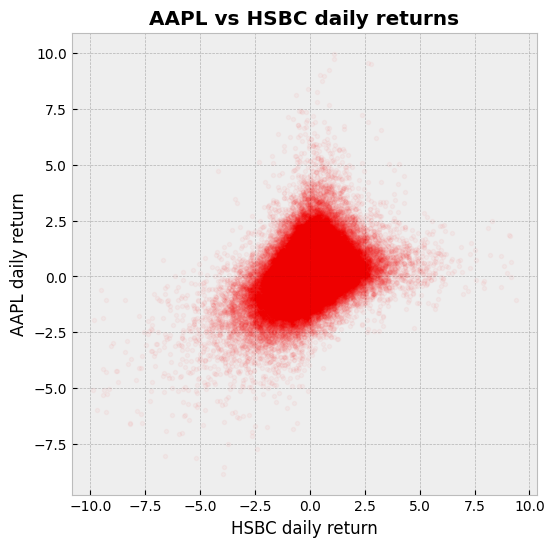

In [ ]:
idx = (return_simulations['HSBC'] > -10) & (return_simulations['HSBC'] < 10)
idx = idx & (return_simulations['AAPL'] > -10) & (return_simulations['AAPL'] < 10)

x = return_simulations.loc[idx, 'HSBC']
y = return_simulations.loc[idx, 'AAPL']

fig = plt.figure()
fig.set_size_inches(6,6)

# fft_axes = fig.add_subplot(212)

plt.plot(x, y, "r.", alpha=0.03)
plt.xlabel("HSBC daily return")
plt.ylabel("AAPL daily return")
plt.title("AAPL vs HSBC daily returns", weight="bold")
plt.show()

Перейдем к бэктесту -- напишем еще пару функций для моделирования совместного распределения доходностей

In [ ]:
def make_dummy_student_simulations(returns, n_samples):
    
    return_simulations = {}

    for col in returns.columns:
        t_df, t_mean, t_sigma = scipy.stats.t.fit(returns[col])
        return_simulations[col] = scipy.stats.t.rvs(t_df, loc=t_mean, scale=t_sigma, size=n_samples, random_state=42)

    return_simulations = pd.DataFrame(return_simulations)

    return return_simulations


def make_mult_normal_simulations(returns, n_samples):

    mean = np.mean(returns.values, axis=0)
    cov = np.cov(returns.values, rowvar=False)

    return_simulations = scipy.stats.multivariate_normal.rvs(mean=mean, cov=cov, size=n_samples, random_state=42)

    return_simulations = pd.DataFrame(return_simulations, columns=returns.columns)

    return return_simulations


Наконец, перейдем к самому бэктесту!

In [ ]:
%%capture
alpha = 0.05

w = np.ones(shape=(returns.shape[1],)) / 5

# определяем параметры бэктеста
T = len(ret)
T_start = 100
estimation_window = 500
testing_window = T - estimation_window

VaR_curve_HS = []
VaR_curve_student = []
VaR_curve_multivariate_normal = []
VaR_curve_copula_t = []
VaR_curve_copula_garch = []

# в цикле проходимся по всем дням в выборке
for t in range(estimation_window+T_start, T):
    
    # фиксируем часть выборки
    current_estimation_sample = returns[t-estimation_window:t]
    
    # различными способами оцениваем ВаР и сохраняем значения
    protfolio = np.dot(current_estimation_sample.values, w)
    VaR_curve_HS.append(np.quantile(protfolio, alpha))
    
    student_simulation = make_dummy_student_simulations(current_estimation_sample, 10**4)
    VaR_curve_student.append(np.quantile(np.dot(student_simulation.values, w), alpha))
    
    multivariate_normal_simulation = make_mult_normal_simulations(current_estimation_sample, 10**4)
    VaR_curve_multivariate_normal.append(np.quantile(np.dot(multivariate_normal_simulation.values, w), alpha))
    
    copula_t_simulation = make_copula_simulation(current_estimation_sample, ClaytonCopula, n_samples=10**4, univariate_dist='t', count_lag=1)
    VaR_curve_copula_t.append(np.quantile(np.dot(copula_t_simulation.values, w), alpha))
    
    copula_garch_simulation = make_copula_simulation(current_estimation_sample, ClaytonCopula,
                                                     n_samples=10**4, univariate_dist='garch', count_lag=1)
    VaR_curve_copula_garch.append(np.quantile(np.dot(copula_garch_simulation.values, w), alpha))
    
    
VaR_curve_HS = pd.Series(VaR_curve_HS, index=ret[estimation_window+T_start:].index)
VaR_curve_student = pd.Series(VaR_curve_student, index=ret[estimation_window+T_start:].index)
VaR_curve_multivariate_normal = pd.Series(VaR_curve_multivariate_normal, index=ret[estimation_window+T_start:].index)

VaR_curve_copula_t = pd.Series(VaR_curve_copula_t, index=ret[estimation_window+T_start:].index)
VaR_curve_copula_garch = pd.Series(VaR_curve_copula_garch, index=ret[estimation_window+T_start:].index)

portfolio = np.dot(returns[estimation_window+T_start:].values, w)
portfolio = pd.Series(portfolio, index=ret[estimation_window+T_start:].index)

Посмотрим на график доходностей и на VaR кривые

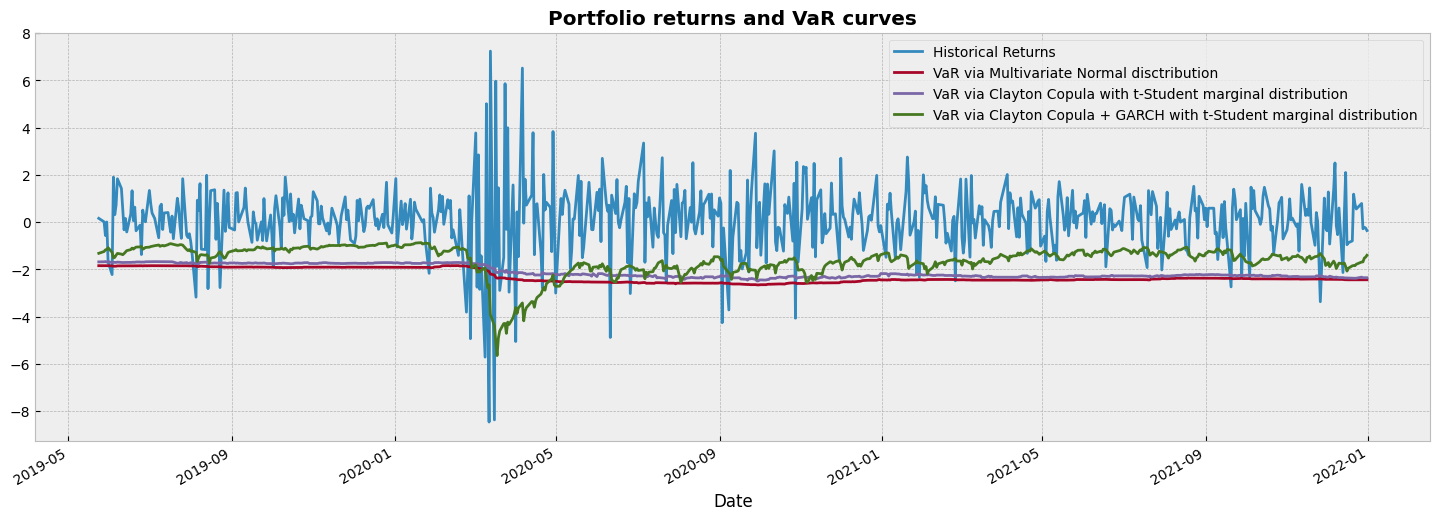

In [ ]:
fig = plt.figure()
fig.set_size_inches(18,6)
portfolio.plot()
# VaR_curve_HS.plot()
# VaR_curve_student.plot()
VaR_curve_multivariate_normal.plot()
VaR_curve_copula_t.plot()
VaR_curve_copula_garch.plot()

plt.title("Portfolio returns and VaR curves", weight="bold")

plt.legend(['Historical Returns',
#             'VaR via Historical Simulation',
#             'VaR via t-Student distribution',
            'VaR via Multivariate Normal disctribution',
            'VaR via Clayton Copula with t-Student marginal distribution',
           'VaR via Clayton Copula + GARCH with t-Student marginal distribution'])
plt.show()

Проведем тесты Купика

In [ ]:
kupiec_test(VaR_curve_HS, portfolio)

Количество наблюдений: 658
Желаемый уровень пробитий: 5.0%
Уровень пробитий в модели: 4.56%

p-value теста: 0.599

При уровне значимости 10% гипотеза гипотеза о
том, что эмпирическая и модельная частоты превышений фактическими
убытками границы VaR равны, НЕ ОТВЕРГАЕТСЯ


In [ ]:
kupiec_test(VaR_curve_student, portfolio)

Количество наблюдений: 658
Желаемый уровень пробитий: 5.0%
Уровень пробитий в модели: 9.88%

p-value теста: 0.000

При уровне значимости 10.0% гипотеза гипотеза о
том, что эмпирическая и модельная частоты превышений фактическими
убытками границы VaR равны, отвергается


In [ ]:
kupiec_test(VaR_curve_multivariate_normal, portfolio)

Количество наблюдений: 658
Желаемый уровень пробитий: 5.0%
Уровень пробитий в модели: 4.10%

p-value теста: 0.277

При уровне значимости 10% гипотеза гипотеза о
том, что эмпирическая и модельная частоты превышений фактическими
убытками границы VaR равны, НЕ ОТВЕРГАЕТСЯ


In [ ]:
kupiec_test(VaR_curve_copula_t, portfolio)

Количество наблюдений: 658
Желаемый уровень пробитий: 5.0%
Уровень пробитий в модели: 5.02%

p-value теста: 0.986

При уровне значимости 10% гипотеза гипотеза о
том, что эмпирическая и модельная частоты превышений фактическими
убытками границы VaR равны, НЕ ОТВЕРГАЕТСЯ


In [ ]:
kupiec_test(VaR_curve_copula_garch, portfolio)

Количество наблюдений: 658
Желаемый уровень пробитий: 5.0%
Уровень пробитий в модели: 7.90%

p-value теста: 0.002

При уровне значимости 10.0% гипотеза гипотеза о
том, что эмпирическая и модельная частоты превышений фактическими
убытками границы VaR равны, отвергается


Как мы видим, самое большое p-value, а также самый близкий к нужному нам уровень пробоев оказался как раз-таки у Copula-GARCH модели.


----------


Теперь перейдем к финальному этапу -- получению из всего это выгоды. Напишем функцию, которая подбирает веса портфеля таким образом, чтобы минимизировать его риск (то есть Value-at-Risk)

In [ ]:
from scipy.optimize import minimize

# объявляем целевую функцию, которую мы будем минимизировать (поэтому в нужных местах ставим минусы)
def calculate_objective_function(weights, returns_simulation, alpha, objective_type):
    
    portfolio_simulation = np.dot(returns_simulation.values, weights)
    
    if objective_type == 'return':
        return -np.mean(portfolio_simulation)
    
    elif objective_type == 'var':
        return -np.quantile(portfolio_simulation, alpha)
    
    
def optimize(returns_simulation, alpha=0.05, objective_type='var'):
        
    init_guess = np.ones(shape=(returns.shape[1],)) / returns.shape[1]
    
    # вот тут можно поставить другие ограничения, например от -1 до 1, чтобы появилась возможность шортить -- продавать какие-то акции
    bounds = ((0.0, 1.0),) * returns.shape[1]
    
    weights = minimize(calculate_objective_function, init_guess,
                       args=(returns_simulation,alpha,objective_type), method='SLSQP',
                       options={'disp': False},
                       constraints=({'type': 'eq', 'fun': lambda inputs: 1.0 - np.sum(inputs)}),
                       bounds=bounds)
    
    return weights.x

Используем эту функцию, чтобы сравнить поведение трех портфелей -- с константными весами, и с весами, которые минимизируют VaR оцененный с помощью многомерного нормального распределения и Copula-GARCH

In [ ]:
%%capture

alpha = 0.05

w = np.ones(shape=(returns.shape[1],)) / 5

T = len(ret)
T_start = 100
estimation_window = 250
testing_window = T - estimation_window

value = 100

value_const_weights = [value]
value_opt_weights_return = [value]
value_opt_weights_var = [value]
value_opt_weights_sharp = [value]
value_opt_weights_return_to_var = [value]
value_opt_weights_es_to_es = [value]

# делаем почти то же самое, что и в бэктесте ВаР
for t in range(estimation_window+T_start, T):
    
    real_returns = returns.iloc[t].values / 100
    
    value_new = np.dot(1+real_returns, w) * value_const_weights[-1]
    value_const_weights.append(value_new)
    
    # фиксируем тренировочное окно и делаем сэмплы
    current_estimation_sample = returns[t-estimation_window:t]
    copula_garch_simulation = make_copula_simulation(current_estimation_sample, ClaytonCopula, n_samples=10**4, univariate_dist='garch', count_lag=1)
    
    # и различными способами оптимизируем веса в портфеле
    w_opt = optimize(copula_garch_simulation, objective_type='return')
    value_new = np.dot(1+real_returns, w_opt) * value_opt_weights_return[-1]
    value_opt_weights_return.append(value_new)
    
    w_opt = optimize(copula_garch_simulation, objective_type='var')
    value_new = np.dot(1+real_returns, w_opt) * value_opt_weights_var[-1]
    value_opt_weights_var.append(value_new)
    
#     w_opt = optimize(copula_garch_simulation, objective_type='sharp')
#     value_new = np.dot(1+real_returns, w_opt) * value_opt_weights_sharp[-1]
#     value_opt_weights_sharp.append(value_new)
    
#     w_opt = optimize(copula_garch_simulation, objective_type='return_to_var')
#     value_new = np.dot(1+real_returns, w_opt) * value_opt_weights_return_to_var[-1]
#     value_opt_weights_return_to_var.append(value_new)
    
#     w_opt = optimize(copula_garch_simulation, objective_type='es_to_es')
#     value_new = np.dot(1+real_returns, w_opt) * value_opt_weights_es_to_es[-1]
#     value_opt_weights_es_to_es.append(value_new)
    
value_const_weights.pop(0)
value_opt_weights_return.pop(0)
value_opt_weights_var.pop(0)
# value_opt_weights_sharp.pop(0)
# value_opt_weights_return_to_var.pop(0)
# value_opt_weights_es_to_es.pop(0)

value_const_weights = pd.Series(value_const_weights, index=ret[estimation_window+T_start:].index)
value_opt_weights_return = pd.Series(value_opt_weights_return, index=ret[estimation_window+T_start:].index)
value_opt_weights_var = pd.Series(value_opt_weights_var, index=ret[estimation_window+T_start:].index)
# value_opt_weights_sharp = pd.Series(value_opt_weights_sharp, index=ret[estimation_window+T_start:].index)
# value_opt_weights_return_to_var = pd.Series(value_opt_weights_return_to_var, index=ret[estimation_window+T_start:].index)
# value_opt_weights_es_to_es = pd.Series(value_opt_weights_es_to_es, index=ret[estimation_window+T_start:].index)

Построим график изменения стоимости нашего портфеля

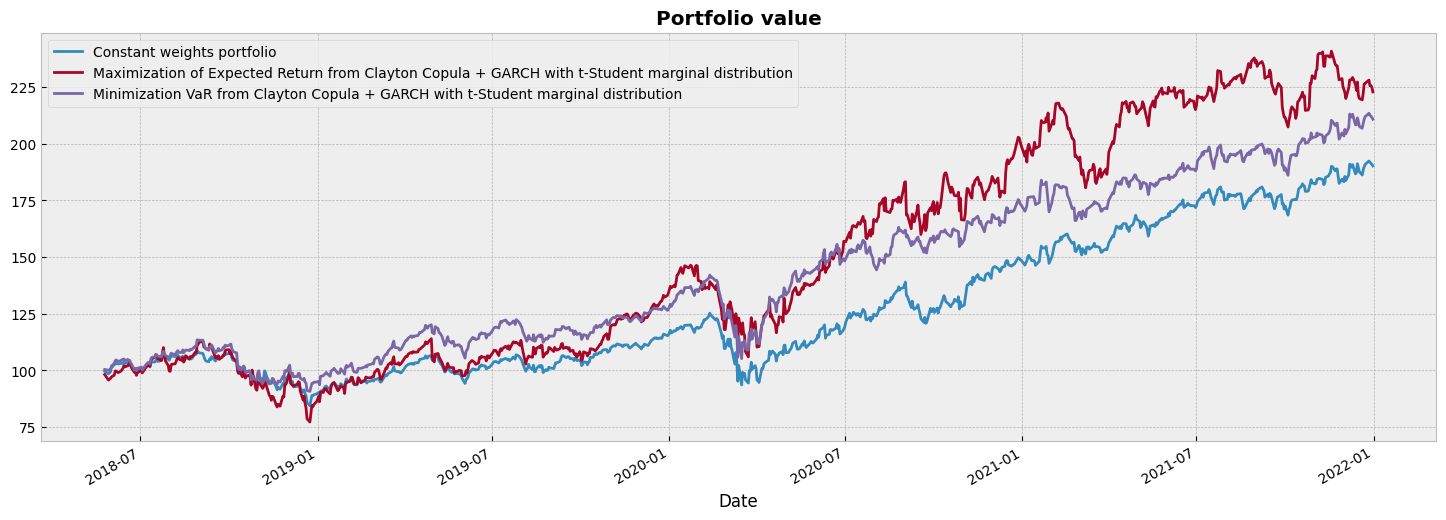

In [ ]:
fig = plt.figure()
fig.set_size_inches(18,6)
value_const_weights.plot()
value_opt_weights_return.plot()
value_opt_weights_var.plot()
# value_opt_weights_sharp.plot()
# value_opt_weights_return_to_var.plot()
# value_opt_weights_es_to_es.plot()

plt.title("Portfolio value", weight="bold")

plt.legend(['Constant weights portfolio',
            'Maximization of Expected Return from Clayton Copula + GARCH with t-Student marginal distribution',
           'Minimization VaR from Clayton Copula + GARCH with t-Student marginal distribution'
#            'Maximization of Sharpe Ratio from Clayton Copula + GARCH with t-Student marginal distribution',
#            'Maximization of ER to VaR from Clayton Copula + GARCH with t-Student marginal distribution',
#            'Maximization of ES/ES from Clayton Copula + GARCH with t-Student marginal distribution'
           ])
plt.show()

Ура! Удивительно, но теория нас не подвела и самой "доходной" оказалась именно модель Copula-GARCH, которая учитывает как временную структуру временного ряда, так и нелинейные зависимости между его активами


Естественно, это не самая лучшая стратегия т.к. мы даже не смотрели на потенциальную доходность активов, а только минимизировали риск.

---------

In [ ]:
%%capture

alpha = 0.1

w = np.ones(shape=(returns.shape[1],)) / 5

T = len(ret)
T_start = 100
estimation_window = 250
testing_window = T - estimation_window

value = 100

value_const_weights = [value]
value_opt_weights_return = [value]
value_opt_weights_var = [value]
value_opt_weights_sharp = [value]
value_opt_weights_return_to_var = [value]
value_opt_weights_es_to_es = [value]

# делаем почти то же самое, что и в бэктесте ВаР
for t in range(estimation_window+T_start, T):
    
    real_returns = returns.iloc[t].values / 100
    
    value_new = np.dot(1+real_returns, w) * value_const_weights[-1]
    value_const_weights.append(value_new)
    
    # фиксируем тренировочное окно и делаем сэмплы
    current_estimation_sample = returns[t-estimation_window:t]
    copula_garch_simulation = make_copula_simulation(current_estimation_sample, StudentCopula, n_samples=10**4, univariate_dist='garch', count_lag=1)
    
    # и различными способами оптимизируем веса в портфеле
    w_opt = optimize(copula_garch_simulation, objective_type='return')
    value_new = np.dot(1+real_returns, w_opt) * value_opt_weights_return[-1]
    value_opt_weights_return.append(value_new)
    
    w_opt = optimize(copula_garch_simulation, objective_type='var')
    value_new = np.dot(1+real_returns, w_opt) * value_opt_weights_var[-1]
    value_opt_weights_var.append(value_new)
    
#     w_opt = optimize(copula_garch_simulation, objective_type='sharp')
#     value_new = np.dot(1+real_returns, w_opt) * value_opt_weights_sharp[-1]
#     value_opt_weights_sharp.append(value_new)
    
#     w_opt = optimize(copula_garch_simulation, objective_type='return_to_var')
#     value_new = np.dot(1+real_returns, w_opt) * value_opt_weights_return_to_var[-1]
#     value_opt_weights_return_to_var.append(value_new)
    
#     w_opt = optimize(copula_garch_simulation, objective_type='es_to_es')
#     value_new = np.dot(1+real_returns, w_opt) * value_opt_weights_es_to_es[-1]
#     value_opt_weights_es_to_es.append(value_new)
    
value_const_weights.pop(0)
value_opt_weights_return.pop(0)
value_opt_weights_var.pop(0)
# value_opt_weights_sharp.pop(0)
# value_opt_weights_return_to_var.pop(0)
# value_opt_weights_es_to_es.pop(0)

value_const_weights = pd.Series(value_const_weights, index=ret[estimation_window+T_start:].index)
value_opt_weights_return = pd.Series(value_opt_weights_return, index=ret[estimation_window+T_start:].index)
value_opt_weights_var = pd.Series(value_opt_weights_var, index=ret[estimation_window+T_start:].index)
# value_opt_weights_sharp = pd.Series(value_opt_weights_sharp, index=ret[estimation_window+T_start:].index)
# value_opt_weights_return_to_var = pd.Series(value_opt_weights_return_to_var, index=ret[estimation_window+T_start:].index)
# value_opt_weights_es_to_es = pd.Series(value_opt_weights_es_to_es, index=ret[estimation_window+T_start:].index)

In [ ]:
fig = plt.figure()
fig.set_size_inches(18,6)
value_const_weights.plot()
value_opt_weights_return.plot()
value_opt_weights_var.plot()
# value_opt_weights_sharp.plot()
# value_opt_weights_return_to_var.plot()
# value_opt_weights_es_to_es.plot()

plt.title("Portfolio value", weight="bold")

plt.legend(['Constant weights portfolio',
            'Maximization of Expected Return from Clayton Copula + GARCH with t-Student marginal distribution',
           'Minimization VaR from Clayton Copula + GARCH with t-Student marginal distribution'
#            'Maximization of Sharpe Ratio from Clayton Copula + GARCH with t-Student marginal distribution',
#            'Maximization of ER to VaR from Clayton Copula + GARCH with t-Student marginal distribution',
#            'Maximization of ES/ES from Clayton Copula + GARCH with t-Student marginal distribution'
           ])
plt.show()

In [ ]:
%%capture

alpha = 0.1

w = np.ones(shape=(returns.shape[1],)) / 5

T = len(ret)
T_start = 100
estimation_window = 250
testing_window = T - estimation_window

value = 100

value_const_weights = [value]
value_opt_weights_return = [value]
value_opt_weights_var = [value]
value_opt_weights_sharp = [value]
value_opt_weights_return_to_var = [value]
value_opt_weights_es_to_es = [value]

# делаем почти то же самое, что и в бэктесте ВаР
for t in range(estimation_window+T_start, T):
    
    real_returns = returns.iloc[t].values / 100
    
    value_new = np.dot(1+real_returns, w) * value_const_weights[-1]
    value_const_weights.append(value_new)
    
    # фиксируем тренировочное окно и делаем сэмплы
    current_estimation_sample = returns[t-estimation_window:t]
    copula_garch_simulation = make_copula_simulation(current_estimation_sample, GumbelCopula, n_samples=10**4, univariate_dist='garch', count_lag=1)
    
    # и различными способами оптимизируем веса в портфеле
    w_opt = optimize(copula_garch_simulation, objective_type='return')
    value_new = np.dot(1+real_returns, w_opt) * value_opt_weights_return[-1]
    value_opt_weights_return.append(value_new)
    
    w_opt = optimize(copula_garch_simulation, objective_type='var')
    value_new = np.dot(1+real_returns, w_opt) * value_opt_weights_var[-1]
    value_opt_weights_var.append(value_new)
    
#     w_opt = optimize(copula_garch_simulation, objective_type='sharp')
#     value_new = np.dot(1+real_returns, w_opt) * value_opt_weights_sharp[-1]
#     value_opt_weights_sharp.append(value_new)
    
#     w_opt = optimize(copula_garch_simulation, objective_type='return_to_var')
#     value_new = np.dot(1+real_returns, w_opt) * value_opt_weights_return_to_var[-1]
#     value_opt_weights_return_to_var.append(value_new)
    
#     w_opt = optimize(copula_garch_simulation, objective_type='es_to_es')
#     value_new = np.dot(1+real_returns, w_opt) * value_opt_weights_es_to_es[-1]
#     value_opt_weights_es_to_es.append(value_new)
    
value_const_weights.pop(0)
value_opt_weights_return.pop(0)
value_opt_weights_var.pop(0)
# value_opt_weights_sharp.pop(0)
# value_opt_weights_return_to_var.pop(0)
# value_opt_weights_es_to_es.pop(0)

value_const_weights = pd.Series(value_const_weights, index=ret[estimation_window+T_start:].index)
value_opt_weights_return = pd.Series(value_opt_weights_return, index=ret[estimation_window+T_start:].index)
value_opt_weights_var = pd.Series(value_opt_weights_var, index=ret[estimation_window+T_start:].index)
# value_opt_weights_sharp = pd.Series(value_opt_weights_sharp, index=ret[estimation_window+T_start:].index)
# value_opt_weights_return_to_var = pd.Series(value_opt_weights_return_to_var, index=ret[estimation_window+T_start:].index)
# value_opt_weights_es_to_es = pd.Series(value_opt_weights_es_to_es, index=ret[estimation_window+T_start:].index)